In [39]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [56]:
alpha = 30.828
beta = 86.688
delta = 3.522*10**-4
gamma = 0.1
Tin = 104.9
cin = 5.1*10**3
k10 = 1.287*10**12
k20 = 9.043*10**6
E1 = 9758.3
E2 = 8560.0
HAB = 4.2
HBC = -11.0
HAD = -41.85

nx = 4 #状態変数の次元
nu = 2 #制御変数の次元
nw = nx #プロセスノイズの次元
ny = 2 #観測状態の次元
nv = ny

# コスト関数の重み
Q_MPC = casadi.diag([0.2,1,0.5,0.2])
Q_f_MPC = casadi.diag([0.2,1,0.5,0.2])
R_MPC = casadi.diag([0.05,5e-3])

Q_MHE = casadi.diag([10,10,10,10])
Q_i_MHE = casadi.diag([0.01,0.01,0.01,0.01]) * 0
R_MHE = casadi.diag([10,10])

# 予測ホライズン等
T = 1/3
K = 40
dt = T/K

# 制約条件
x_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
x_ub = [np.inf,np.inf,np.inf,np.inf]
u_lb = [3,-9000]
u_ub = [35,0]
w_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
w_ub = [np.inf,np.inf,np.inf,np.inf]
v_lb = [-np.inf,-np.inf]
v_ub = [np.inf,np.inf]

# 目標
x_ref = casadi.DM([ 1.37e3, 0.95e3, 110.0, 108.6])
u_ref = casadi.DM([ 5.0, -1190.0])

# 目標2
# x_ref = casadi.DM([2.02e3,1.07e3,100.0,97.1])
# u_ref = casadi.DM([5.0,-2540.0])

total_MPC = nx*(K+1) + nu*K
total_MHE = nx*(K+1) + nw*K + nu*K + ny*K + nv*K + nx

In [57]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    noises = casadi.SX.sym("noises",nw)

    Ca = states[0]
    Cb = states[1]
    TR = states[2]
    TC = states[3]
    u1 = ctrls[0]
    u2 = ctrls[1]

    k1 = k10*casadi.exp(-E1/(TR+273.15))
    k2 = k20*casadi.exp(-E2/(TR+273.15))

    Ca_dot = -k1*Ca - k2*Ca**2 +(cin - Ca)*u1
    Cb_dot = k1*Ca - k1*Cb - Cb*u1
    TR_dot = -delta*(k1*Ca*HAB + k1*Cb*HBC + k2*Ca**2*HAD) + alpha*(TC-TR) + (Tin - TR)*u1
    TC_dot = beta*(TR-TC) + gamma*u2

    states_dot = casadi.vertcat(Ca_dot,Cb_dot,TR_dot,TC_dot) + noises

    f = casadi.Function("f",[states,ctrls,noises],[states_dot],['x','u',"w"],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    noises = casadi.SX.sym("noises",nw)

    f = make_f()

    k1 = f(x=states,u=ctrls,w=noises)["x_dot"]
    k2 = f(x=states+dt*k1/2,u=ctrls,w=noises)["x_dot"]
    k3 = f(x=states+dt*k2/2,u=ctrls,w=noises)["x_dot"]
    k4 = f(x=states+dt*k3,u=ctrls,w=noises)["x_dot"]

    states_next = states + dt*(k1+2*k2+2*k3+k4)/6

    RK4 = casadi.Function("RK4",[states,ctrls,noises],[states_next],["x","u","w"],["x_next"])
    return RK4

def make_h():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    onoises = casadi.SX.sym("onoises",nv)

    C = casadi.DM([
        [0,0,1,0],
        [0,0,0,1]
    ])

    observes = C @ states + onoises

    h = casadi.Function("h",[states,ctrls,onoises],[observes],['x',"u","v"],['y'])
    return h

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)
    noises = casadi.SX.sym("noises",nw)

    f = make_f()
    ode = f(x=states, u=ctrls,w=noises)["x_dot"]
    params = casadi.vertcat(ctrls,noises)
    dae = {"x":states,"p":params,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_MPC_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q_MPC@x_diff,x_diff) + casadi.dot(R_MPC@u_diff,u_diff)) / 2
    return cost

def compute_MPC_final_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f_MPC@x_diff,x_diff) / 2
    return cost

def compute_MHE_stage_cost(w,v):
    cost = (casadi.dot(Q_MHE@w,w) + casadi.dot(R_MHE@v,v)) / 2
    return cost

def compute_MHE_initial_cost(x_diff):
    cost = casadi.dot(Q_i_MHE@x_diff,x_diff) / 2
    return cost

In [58]:
def make_MPC_nlp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_MPC_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_MPC_final_cost(X[-1])

    option = {'print_time':False,'ipopt':{'max_iter':1000,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S_MPC","ipopt",nlp,option)
    return S

def make_MHE_nlp():
    RK4 = make_RK4()
    h = make_h()

    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    Y = [casadi.SX.sym(f"y_{i}",ny) for i in range(K)]
    W = [casadi.SX.sym(f"w_{i}",nw) for i in range(K)]
    V = [casadi.SX.sym(f"v_{i}",nv) for i in range(K)]
    x_hat = casadi.SX.sym("x_hat",nx)
    G = []

    J = 0
    x_diff = X[0] - x_hat
    J += compute_MHE_initial_cost(x_diff)
    for k in range(K):
        J += compute_MHE_stage_cost(W[k],V[k]) * dt
        state_eq = X[k+1] - RK4(x=X[k],u=U[k],w=W[k])["x_next"]
        obs_eq = Y[k] - h(x=X[k],u=U[k],v=V[k])["y"]
        G.append(state_eq)
        G.append(obs_eq)

    option = {'print_time':False,'ipopt':{'max_iter':1000,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*W,*U,*Y,*V,x_hat),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S_MHE","ipopt",nlp,option)
    return S

In [59]:
def compute_optimal_control(S,x_s,x0):
    x_s = x_s.full().ravel().tolist()
    
    lbx = x_s + x_lb*K + u_lb*K
    ubx = x_s + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

def compute_optimal_estimation(S,us,ys,x0,x_hat):
    lbx = x_lb*(K+1) + w_lb*K + us + ys + v_lb*K + x_hat
    ubx = x_ub*(K+1) + w_ub*K + us + ys + v_ub*K + x_hat
    lbg = ([0]*nx + [0]*ny)*K
    ubg = ([0]*nx + [0]*ny)*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    # offset = nx*(N+1)
    x0 = res["x"]
    return x0

In [60]:
S_MPC = make_MPC_nlp()
S_MHE = make_MHE_nlp()

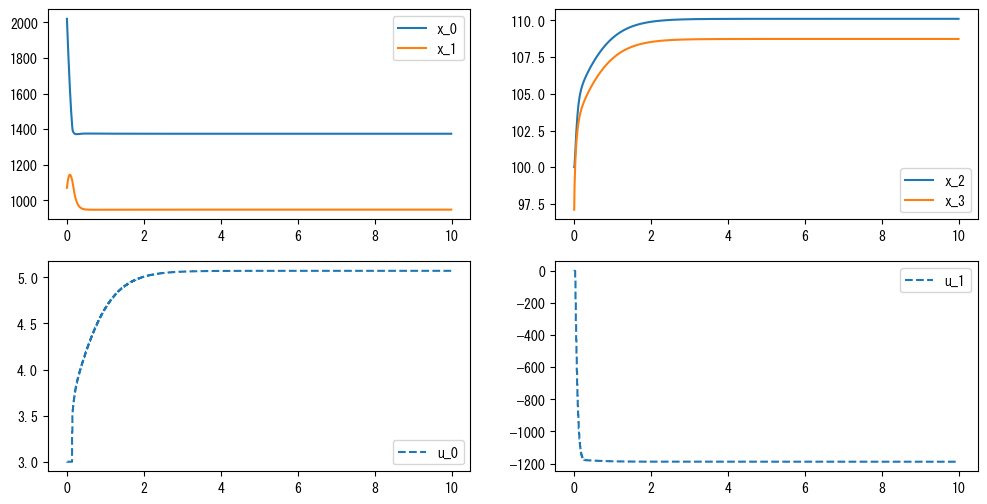

In [63]:
I = make_integrator()
h = make_h()

t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([2.02e3, 1.07e3, 100.0, 97.1]) # 初期値
x0 = casadi.DM.zeros(total_MPC)

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S_MPC,x_current,x0)
    p_current = casadi.vertcat(u_opt,casadi.DM.zeros(nw))
    x_current = I(x0=x_current,p=p_current)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
for k in range(2):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
    plt.legend()

plt.subplot(2,2,2)
for k in range(2,nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
    plt.legend()

plt.subplot(2,2,3)
plt.step(t_eval,U[:,0],linestyle="--",label="u_0")
plt.legend()

plt.subplot(2,2,4)
plt.step(t_eval,U[:,1],linestyle="--",label="u_1")
plt.legend()

plt.savefig("./images/chap8_CSTR_mpc.png")
plt.show()

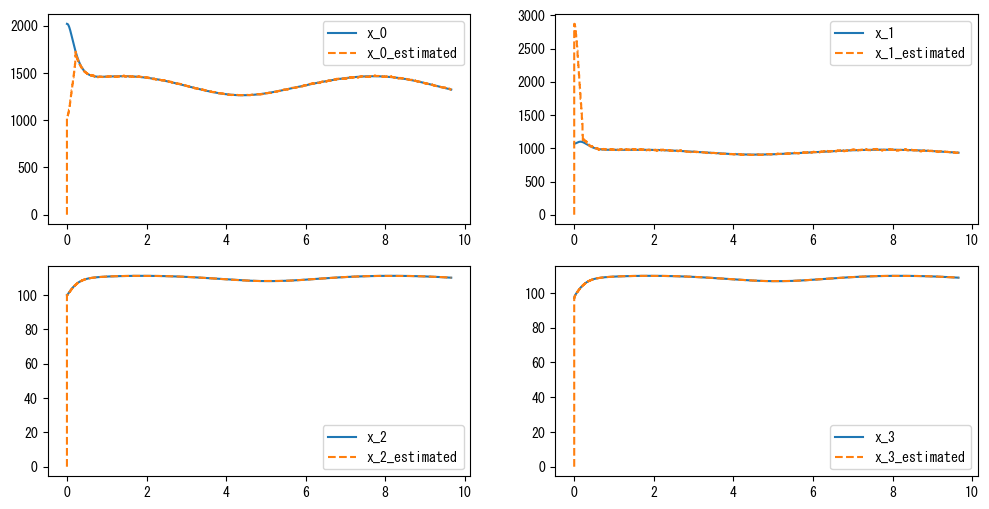

In [71]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)

I = make_integrator()
h = make_h()

x_init = casadi.DM([2.02e3, 1.07e3, 100.0, 97.1]) # 初期値

x_hat = casadi.DM([2.02e3+100, 1.07e3+100, 100.0+5, 97.1-7])*0
# x0 = make_x0(x_hat)
x0 = casadi.DM.zeros(total_MHE)

X = [x_init]
X_est = [x_hat]
U = []
Y = []
x_current = x_init
for t in t_eval:
    if len(Y) >= K:
        ys = casadi.vertcat(*Y[-K:]).full().ravel().tolist()
        us = casadi.vertcat(*U[-K:]).full().ravel().tolist()
        x_hat_list = x_hat.full().ravel().tolist()
        x0 = compute_optimal_estimation(S_MHE,us,ys,x0,x_hat_list)
        x_hat = x0[:nx]
        X_est.append(x_hat)
    u_current = np.array([ 5.0, -1190.0]) + np.sin(t)
    w_current = np.random.normal(scale=1e-3,size=(nw,))
    v_current = np.random.normal(scale=1e-3,size=(nv,))
    p_current = casadi.DM([*u_current,*w_current])
    y_current = h(x=x_current,u=u_current,v=v_current)["y"]
    x_current = I(x0=x_current,p=p_current)["xf"]
    X.append(x_current)
    Y.append(y_current)
    U.append(u_current)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
X_est.pop()
X_est = np.array(X_est).reshape(-1,nx)

plt.figure(figsize=(12,6))
for i in range(nx):
    plt.subplot(2,2,i+1)
    plt.plot(t_eval[:-K],X[:-K,i],label=f"x_{i}")
    plt.step(t_eval[:-K],X_est[:,i],linestyle="--",label=f"x_{i}_estimated")
    plt.legend()

plt.savefig("images/chap8_CSTR_MHE.png")
plt.show()

CasADi - 2024-01-23 22:48:39 WARNING("S_MHE:nlp_g failed: Inf detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:326]


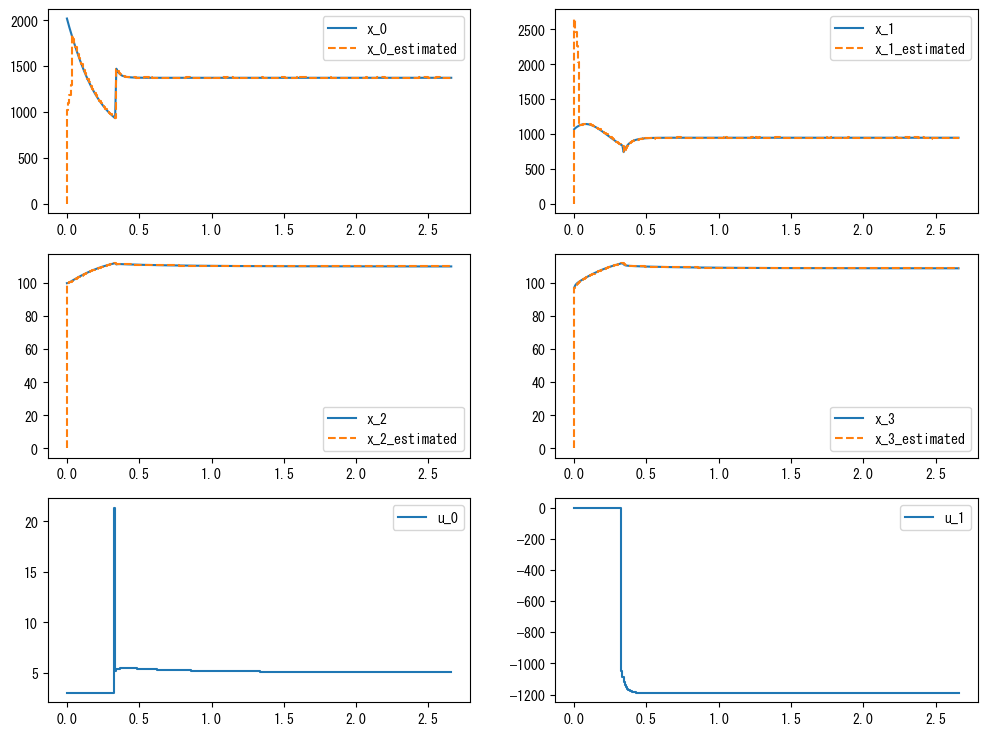

In [73]:
t_span = [0,3]
t_eval = np.arange(*t_span,dt)

I = make_integrator()
h = make_h()

x_init = casadi.DM([2.02e3, 1.07e3, 100.0, 97.1]) # 初期値

x_hat = casadi.DM([2.02e3+100, 1.07e3+100, 100.0+5, 97.1-7])*0
x0_MPC = casadi.DM.zeros(total_MPC)
x0_MHE = casadi.DM.zeros(total_MHE)

X = [x_init]
X_est = [x_hat]
U = []
Y = []
x_current = x_init
x_current_est = x_hat
for t in t_eval:
    if len(Y) >= K:
        ys = casadi.vertcat(*Y[-K:]).full().ravel().tolist()
        us = casadi.vertcat(*U[-K:]).full().ravel().tolist()
        x_hat_list = x_hat.full().ravel().tolist()
        x0_MHE = compute_optimal_estimation(S_MHE,us,ys,x0_MHE,x_hat_list)
        x_hat = x0_MHE[:nx]
        X_est.append(x_hat)
        x_current_est = x0_MHE[nx*K:nx*(K+1)]
    u_current,x0_MPC = compute_optimal_control(S_MPC,x_current_est,x0_MPC)
    w_current = casadi.DM(np.random.normal(scale=1e-3,size=(nw,)))
    v_current = np.random.normal(scale=1e-3,size=(nv,))
    p_current = casadi.vertcat(u_current,w_current)
    y_current = h(x=x_current,u=u_current,v=v_current)["y"]
    x_current = I(x0=x_current,p=p_current)["xf"]
    X.append(x_current)
    Y.append(y_current)
    U.append(u_current)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
X_est.pop()
X_est = np.array(X_est).reshape(-1,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,9))
for i in range(nx):
    plt.subplot(3,2,i+1)
    plt.plot(t_eval[:-K],X[:-K,i],label=f"x_{i}")
    plt.step(t_eval[:-K],X_est[:,i],linestyle="--",label=f"x_{i}_estimated")
    plt.legend()

for i in range(nu):
    plt.subplot(3,2,nx+i+1)
    plt.step(t_eval[:-K],U[:-K,i],label=f"u_{i}")
    plt.legend()

plt.savefig("images/chap8_CSTR_MPCxMHE.png")
plt.show()